# JupyerLab notebook example for Pulse Structure investigations

/!\ /!\ /!\  
Oxygen diffusion from cell environment not (yet) included in the model.  
Therefore, the oxygen level is reinitialized before each new pulse.  

## Module imports

In [1]:
# External modules (to "pip install")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modules from Standard lib
from pathlib import Path
from scipy.integrate import simpson, solve_ivp  # type: ignore[import]

# RadioBio module
import radiopyo as rp

In [5]:
from Plot_template import RPlot, FigManager
RPlot.init_rcparams()
fig_man = FigManager()

## Simulation Run

**1) Load configuration from the toml file +**  
 -> create a ref to O2 species for later use  
 -> define the desired number of pulses  
 -> define the period

In [6]:
file = Path(rf"configuration_PULSESTRUCT.toml")
uc = rp.UnitCell.from_toml(file)

O2 = uc.env.species.get("O2")


2023-06-08 15:37:46,503::radiopyo::INFO::Loading config from TOML file: configuration_PULSESTRUCT.toml
2023-06-08 15:37:46,508::radiopyo::INFO::File is loaded
2023-06-08 15:37:46,509::radiopyo::INFO::Beam configuration detected in config file
2023-06-08 15:37:46,509::radiopyo::INFO::Beam PulsedBeam(dose_rate=5.0, timer=Timer(period=0.2, on_time=0.001, start_time=0.0), max_dose=5, time_at_max_dose=0.801, dose_per_pulse=1.0, peak_dose_rate=1000.0) is setup
2023-06-08 15:37:46,510::radiopyo::INFO::CONFIG::Configuring Simulation Environment
2023-06-08 15:37:46,511::radiopyo::INFO::CONFIG::3 Acid/Base reactions added
2023-06-08 15:37:46,512::radiopyo::INFO::CONFIG::38 K-reactions added
2023-06-08 15:37:46,512::radiopyo::INFO::CONFIG::1 Enzymatic reactions added
2023-06-08 15:37:46,513::radiopyo::INFO::CONFIG::6 Radiolytic reactions added
2023-06-08 15:37:46,514::radiopyo::INFO::CONFIG::19 Dynamical Species added.
2023-06-08 15:37:46,514::radiopyo::INFO::CONFIG::9 Constant Species added.
202

NameError: name 'uc' is not defined

## Simulation Run LOOP

In [8]:
import itertools as it
rp.set_logging_level("ERROR")

In [9]:
PERIODS = [2e-3, 5e-3, 10e-3, 15e-3, 20e-3, 100e-3, 500e-3, 750e-3, 1, 5]
#DR = [100, 500, 1000, 5000, 1e4]
chunks = dict()
all_res = pd.DataFrame()
sims = dict()

for idx, period in enumerate(PERIODS):
    print(f"Simulating: {period:.2g} s")
    beam_def["period"] = period
    uc.set_beam(rp.physics.beam.PulsedBeam.from_dict(beam_def))
    #beam_def["dose_rate"] = period
    #uc.set_beam(rp.physics.beam.ConstantBeam.from_dict(beam_def))
    res = uc.prepare_chunked_run([1e-9, 500],
                                 max_step_size_on=uc.beam.timer.on_time/5e4,
                                 max_step_size_off=0.05,
                                 max_step_size_final=0.05,
                                 atol=1e-12)
    chunks[period] = res.chunks.copy()
    res = res.run()
    sims[period] = res
    
    all_res.loc[:, idx] = np.empty(3)
    all_res.iloc[0,idx] = period
    integral = res.integrate_species()
    all_res.iloc[1, idx] = integral["ROO_r"]
    all_res.iloc[2, idx] = integral["R_r"]
    if (idx==2): break

Simulating: 0.002 s


  0%|          | 0/10 [00:00<?, ?it/s]

Simulating: 0.005 s


  0%|          | 0/10 [00:00<?, ?it/s]

Simulating: 0.01 s


  0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
from scipy.interpolate import interp1d

In [54]:
df.columns

Index(['KR_0', 'KR_1', 'KR_2', 'KR_3', 'KR_4', 'KR_5', 'KR_6', 'KR_7', 'KR_8',
       'KR_9', 'KR_10', 'KR_11', 'KR_12', 'KR_13', 'KR_14', 'KR_15', 'KR_16',
       'KR_17', 'KR_18', 'KR_19', 'KR_20', 'KR_21', 'KR_22', 'KR_23', 'KR_24',
       'KR_25', 'KR_26', 'KR_27', 'KR_28', 'KR_29', 'KR_30', 'KR_31', 'KR_32',
       'KR_33', 'KR_34', 'KR_35', 'KR_36', 'KR_37', 'G_e_aq', 'G_OH_r',
       'G_H_r', 'G_H2', 'G_H2O2', 'G_R_r', 'EZ_0'],
      dtype='object')

In [56]:
bins = np.arange(start=0, stop=df.index[-1], step=1e-3)
df.groupby(pd.cut(df["KR_7"], bins=bins)).

In [50]:
new_index = np.arange(start=0, stop=df.index[-1], step=1e-3)
ndf = pd.DataFrame(np.NaN, index=new_index, columns=df.columns)
for key, serr in df.items():
    f = interp1d(x=serr.index, y=serr.values, fill_value="extrapolate")
    ndf[key] = f(ndf.index)

In [16]:
df = sims[0.01].reconstruct_reactions()

In [26]:
pd.Series(df.index).diff().unique()

array([           nan, 1.00000000e-12, 2.97088209e-11, ...,
       3.96167198e-02, 5.00000000e-02, 1.03025835e-02])

In [84]:
import pprint
pprint.pprint(chunks)

{100: [SimChunk(start=1e-09, stop=0.054999999900000006, max_step_size=5e-05),
       SimChunk(start=0.054999999900000006, stop=500.0, max_step_size=1.0)],
 500: [SimChunk(start=1e-09, stop=0.0109999999, max_step_size=1e-05),
       SimChunk(start=0.0109999999, stop=500.0, max_step_size=1.0)],
 1000: [SimChunk(start=1e-09, stop=0.0054999999, max_step_size=5e-06),
        SimChunk(start=0.0054999999, stop=500.0, max_step_size=1.0)],
 5000: [SimChunk(start=1e-09, stop=0.0010999999, max_step_size=1e-06),
        SimChunk(start=0.0010999999, stop=500.0, max_step_size=1.0)],
 10000.0: [SimChunk(start=1e-09, stop=0.0005499999, max_step_size=5e-07),
           SimChunk(start=0.0005499999, stop=500.0, max_step_size=1.0)]}


In [123]:
all_res

,0,1,2,3,4,5,6,7,8
0,0.002000,0.005000,0.010000,0.015000,0.020000,0.100000,0.500000,0.750000,1.000000
1,30.769932,30.884113,31.194627,30.776173,30.776607,30.823215,30.916811,31.397136,31.061414
2,0.000596,0.000599,0.000605,0.000597,0.000597,0.000597,0.000596,0.000613,0.000596


In [169]:
len(sims)

10

## Results usage

**Integrate values per pulse**

In [12]:
by_pulse = pd.DataFrame(columns=df.columns)
for pulse in range(int(PULSES_NUMBER)):
    by_pulse.loc[pulse, :] = res.integrate_species(start=pulse*uc.beam.timer.period, stop=(pulse+1)*uc.beam.timer.period)

### Plot

In [29]:
# Some common plot options for uniformity
RIGHT_LIMIT = 1e3

#### Water-only Radiolytic produced species

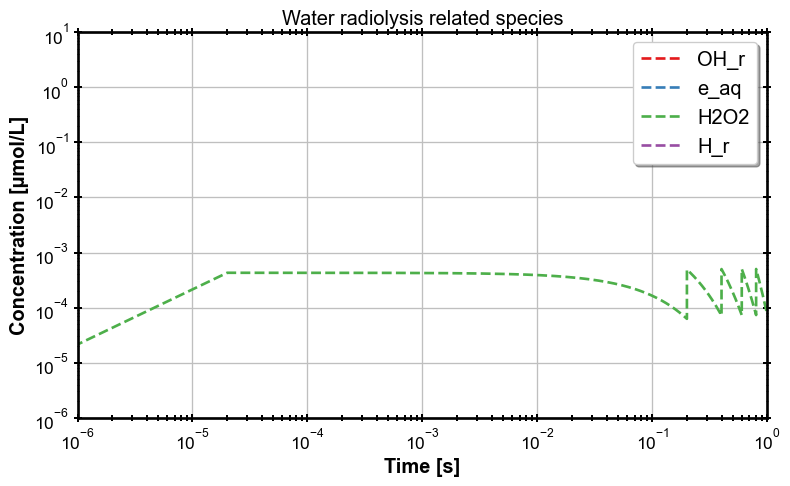

In [24]:
G_species = ["OH_r", "e_aq", "H2O2", "H_r"]

with fig_man.open(f"Water radiolysis related species") as (fig, ax):
    for label in G_species:
        ax.plot(df.index, df[label], label=label, marker="")

    ax.set_ylim(bottom=1e-6, top=10)
    ax.set_xlim([1e-6, RIGHT_LIMIT])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Water radiolysis related species")

#### Biology related species

In [154]:
df["ROO_r"].values[mask]

array([0.00376899, 0.00377043, 0.00377187, ..., 0.01845546, 0.01841767,
       0.01837997])

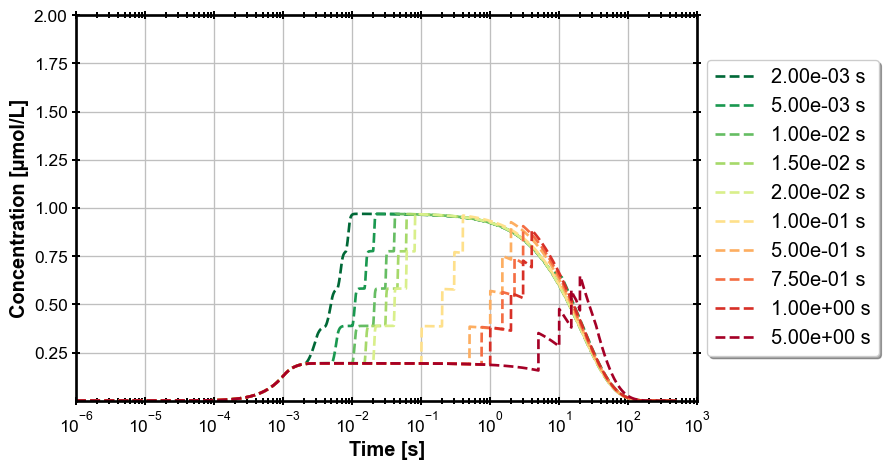

In [180]:
species = "ROO_r"
fig_man.set_brewer_map("RdYlGn", "diverging", 10, reverse=True)
with fig_man.open(f"Comparison of {species}") as (fig, ax):
    for period, df in sims.items():
        ax.plot(df.index, df[species], label=f"{period:.2e} s", marker="")

    ax.set_ylim(bottom=1e-6, top=2)
    ax.set_xlim([1e-6, RIGHT_LIMIT])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    RPlot.set_legend_right(ax)
    #ax.legend(fancybox=True, framealpha=1)
    #ax.set_title("Biology related species")
    fig.savefig(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\BE_FLASH_CONSORTIUM\image.png", transparent=True)

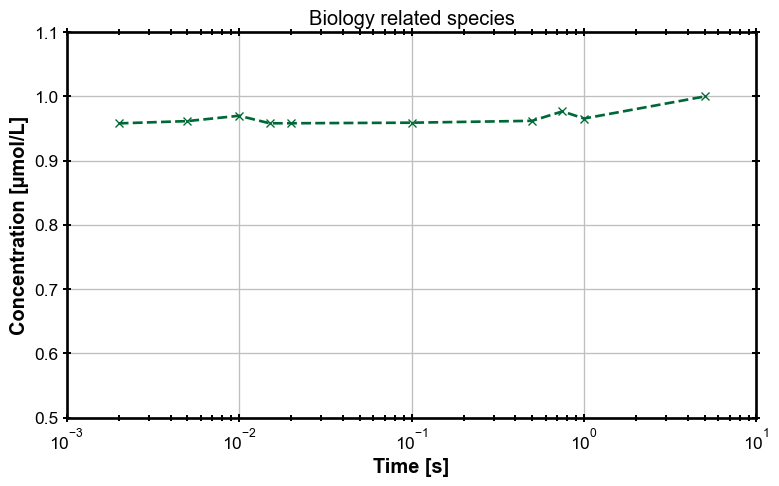

In [174]:
species = "ROO_r"
adf = pd.Series(dtype=np.float64)
for period, df in sims.items():
    mask = np.where((df.index>=1e-4)&(df.index<100))
    adf.loc[period] = simpson(y=df[species].values[mask].clip(min=0), x=df.index[mask])
    
with fig_man.open(f"Comparison of {species} ROO_r") as (fig, ax):
    
    ax.plot(adf.index, adf/adf.max(), marker="x")

    #ax.set_ylim(bottom=1e-6, top=2)
    ax.set_ylim([0.5, 1.1])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")

    ax.set_title("Biology related species")

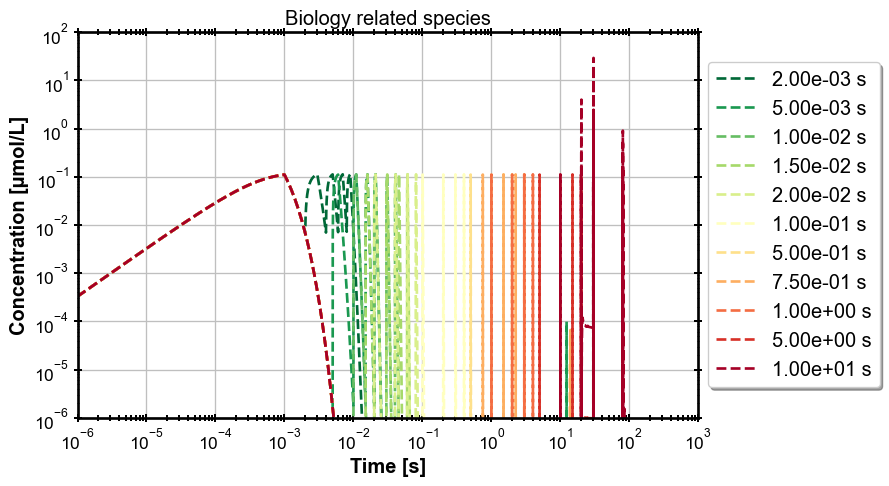

In [165]:
species = "R_r"
with fig_man.open(f"Comparison of {species}") as (fig, ax):
    for period, df in sims.items():
        ax.plot(df.index, df[species], label=f"{period:.2e} s", marker="")

    ax.set_ylim(bottom=1e-6, top=1e2)
    ax.set_xlim([1e-6, RIGHT_LIMIT])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    RPlot.set_legend_right(ax)
    #ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Biology related species")

#### O2

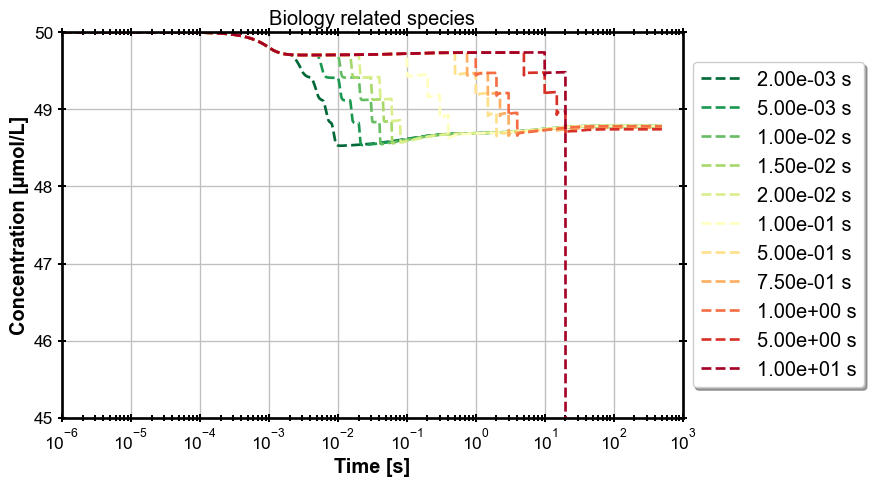

In [166]:
species = "O2"
with fig_man.open(f"Comparison of {species}") as (fig, ax):
    for period, df in sims.items():
        ax.plot(df.index, df[species], label=f"{period:.2e} s", marker="")

    ax.set_ylim(bottom=45, top=50)
    ax.set_xlim([1e-6, RIGHT_LIMIT])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    RPlot.set_legend_right(ax)
    #ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Biology related species")

## Compare Pulses

**Integrate values per pulse**

In [32]:
by_pulse = pd.DataFrame(columns=df.columns)
for pulse in range(int(PULSES_NUMBER)):
    by_pulse.loc[pulse, :] = res.integrate_species(start=pulse*uc.beam.timer.period, stop=(pulse+1)*uc.beam.timer.period)

In [33]:
by_pulse

,OH_r,O_r_minus,H2O2,HO2_minus,HO2_r,O2_r_minus,e_aq,H_r,H2,O2,O2_minus_minus,O3_minus,Fe_plus_plus_plus,RH_r,R_r,ROO_r,ROH,RO,ROOH
0,0.0,0.0,0.000038,0.0,0.0,0.000002,0.0,0.0,0.000063,9.999233,0.0,0.0,0.0,0.000285,0.000001,0.000615,0.0,0.0,0.0
1,0.0,0.0,0.000044,0.0,0.0,0.000004,0.0,0.0,0.000127,9.999921,0.0,0.000039,0.0,0.00053,0.0,0.000683,0.0,0.0,0.0
2,0.0,0.0,0.000044,0.0,0.0,0.000006,0.0,0.0,0.00019,9.999363,0.0,0.000137,0.0,0.000775,0.0,0.000747,0.0,0.0,0.0
3,0.0,0.0,0.000045,0.0,0.0,0.000007,0.0,0.0,0.000253,9.999367,0.0,0.000272,0.0,0.001022,0.0,0.000829,0.0,0.0,0.0
4,0.0,0.0,0.000044,0.0,0.0,0.000009,0.0,0.0,0.000315,9.953993,0.0,0.000429,0.0,0.001263,0.0,0.000911,0.0,0.0,0.0


### ON time

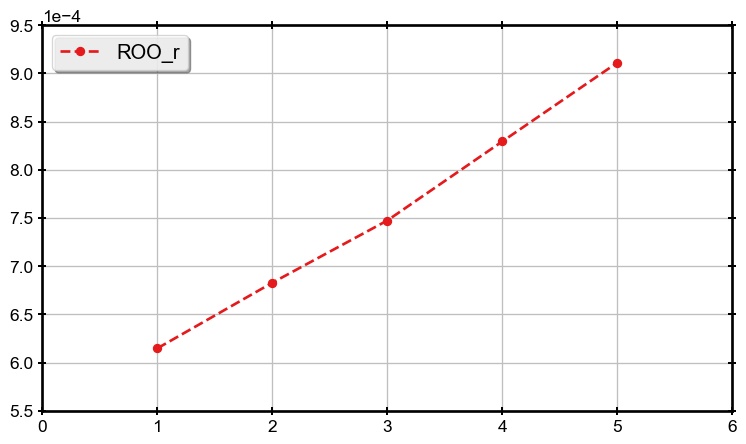

In [36]:
with fig_man.open(f"Pulse Integral") as (fig, ax):
    ax.plot(by_pulse.index+1, by_pulse["ROO_r"], label="ROO_r")
    ax.legend()

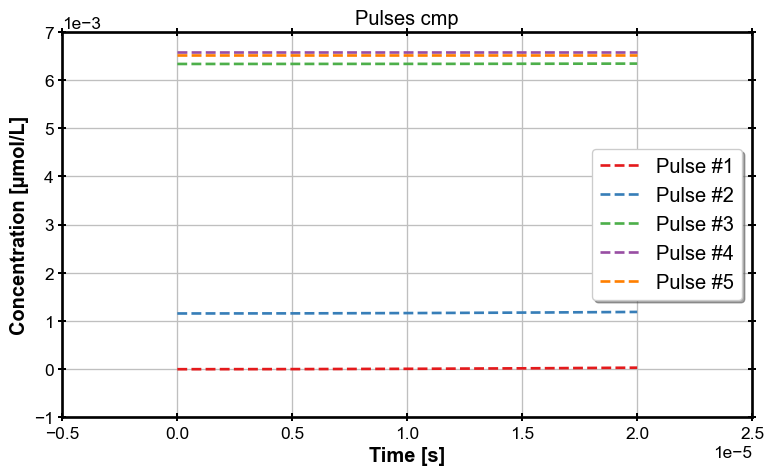

In [27]:
species = "ROO_r"
with fig_man.open(f"Pulses cmp") as (fig, ax):
    for pulse in range(int(PULSES_NUMBER)):
        start_pulse = pulse*uc.beam.timer.period
        mask = (df.index>=start_pulse) & (df.index < start_pulse+uc.beam.timer.on_time)
        ax.plot(df.index[mask]-start_pulse, df.loc[mask, species], label=f"Pulse #{pulse+1}", marker="")

    #ax.set_ylim(bottom=1e-6, top=100)
    #ax.set_xlim([1e-6,1])
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Pulses cmp")

### OFF Time

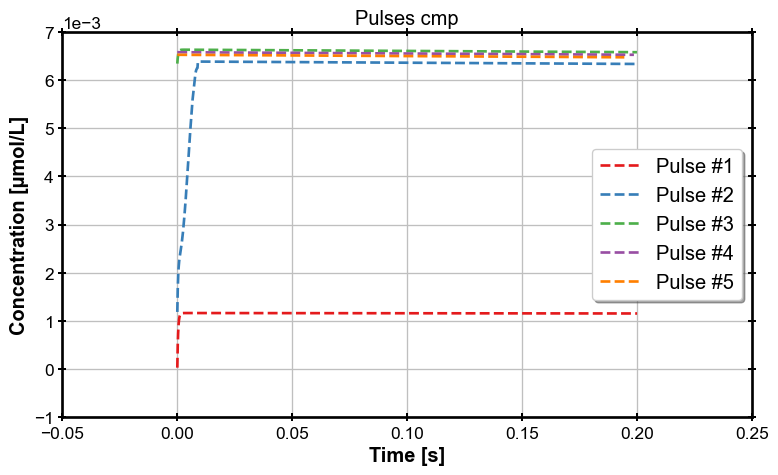

In [28]:
species = "ROO_r"
with fig_man.open(f"Pulses cmp") as (fig, ax):
    for pulse in range(int(PULSES_NUMBER)):
        start_pulse = pulse*uc.beam.timer.period + uc.beam.timer.on_time
        mask = (df.index>=start_pulse) & (df.index < (pulse+1)*uc.beam.timer.period)
        ax.plot(df.index[mask]-start_pulse, df.loc[mask, species], label=f"Pulse #{pulse+1}", marker="")

    #ax.set_ylim(bottom=1e-6, top=100)
    #ax.set_xlim([1e-6,0.12])
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Pulses cmp")